In [21]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('bmh')
%matplotlib inline

pd.options.display.max_rows = 14

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load and explore the dataset

In [22]:
mnist = fetch_mldata('MNIST original')
# What's the structure of the object returned by sklearn?
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

* DESCR should contain more information about the dataset but unfortunately it most often doesn't
* You should find out more information about the dataset on your own
* features are available in `mnist.data`, labels are available in `mnist.target`

In [23]:
mnist.DESCR

'mldata.org dataset: mnist-original'

In [24]:
X = mnist['data']
y = mnist['target']

X.shape, y.shape
np.sqrt(784)

((70000, 784), (70000,))

28.0

* There are 70,000 observations. 784 features/columns. Each observation has the image data in the form of 28x28 pixels per image. 
* To train, use 784 features as it is. 
* To print in image form, convert each observation(e.g. X[432] or X[766]) to 28x28 form using function `reshape`(e.g. X[22].reshape(28, 28))

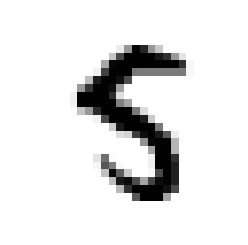

In [25]:
d = X[34911]
l = y[34911]

a = plt.imshow(d.reshape(28, 28), cmap = matplotlib.cm.binary)
a = plt.axis('off')

# what's the label for the above observation?
# l

In [26]:
# Split the set: first 60k observations into training set, remaining 10k observations into test set
X_train, y_train = X[:60000], y[:60000]
X_test, y_test  = X[60000:], y[60000:]

# Shuffle the training set. 
# First compute indices in random order so it can be used on both X_train and y_train; may not be needed if both are in the same dataset
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary Classifier: Is the digit 5 or not?

In [27]:
# Let us create a simple binary classifier that can classify digits 0-9 as two categories: `5` or `not 5`(hence the name)
from sklearn.linear_model import SGDClassifier

# whereever label is 5, set that label to `True` instead
# wherever the label is 0,1,2,3,4,6,7,8,9, set that label to `False` instead
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)   

In [28]:
sgd_clf = SGDClassifier(random_state=42, max_iter=5)
x = sgd_clf.fit(X_train, y_train_5)  # train!

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [34]:
# predict on a sample observation and check with its label
sgd_clf.predict([sample_digit])
l
# Exercise: try out predict() on a few other training observations

array([ True], dtype=bool)

5.0

# Performance Measures

In [30]:
### Calculate accuracy of classification using k-fold cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9645 ,  0.9656 ,  0.94645])

* Is ~94-96% accuracy good? Let us see the accuracy of one of the worst classifiers possible.
* What's the accuracy of the classifier that classifies every number as not being 5

* The following classifier does no training at all. Whenever predict is called, it just returns all 0s in the shape of X.
* Do you understand how reshaping is being done here and why?
* If you forgot how required shape can be passed to `np.zeros`: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.zeros.html

In [31]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [33]:
### Calculate accuracy for this dumb classifier
cross_val_score(Never5Classifier(), X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9124 ,  0.9055 ,  0.91105])

* That's ~90-91% accuracy for this dataset when you always predict `not 5` as the result where the learning part is entirely skipped! 
* Our previous classifier was only ~4% more accurate than one of the worst possible classifiers. 
* Before we think of better classifier models, let us first learn better ways to measure performance  

### A. Confusion Matrix

* Confusion matrix tells us the number of times category A was classified incorrectly as category B, C, D, etc. and similarly for B, C, D, etc.
* E.g. 3rd row and 4th column in the confusion matrix tells us how many times the classifier incorrectyl classified the images of 3 with images of 5.
* To create a confusion matrix we need actual labels and predicted labels. use `cross_val_predict` function in this case to get predictions instead of the scores.

### cross_val_predict vs. cross_val_score & predict
* Exercise: Repeat the following with Never5Classifier if you want to even though you know already what that confusion matrix would look like
* `predict` function gives a prediction after the corresponding label has been seen and trained on already
* Predictions obtained via `cross_val_predict` are generated using cross validation technique
* This means that the predictions were generated without looking at the training labels
* How is this possible?

In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_ps = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 
confusion_matrix(y_train_5, y_ps)

array([[53553,  1026],
       [ 1443,  3978]])

|  | not 5 | 5 |
|:-:|:-:|:-:|
| not 5 |  |   |
        | 5 |  | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |

* How to interpret the above result?
  * Rows = actual class & columns = predicted class
* This means:
  * ~50k of the digits that are not digit 5 were correctly classified as `not 5`. These are called as _true negatives_.
  * ~1k of the digits that are not digit 5 were incorrectly classified as `5`. These are called _false positives_. 
  * ~1.5k of the digits that are digit 5 were incorrectly classified as `not 5`. These are called _false negatives_.
  * ~4k of the digits that are digit 5 were correctly classified as `5`. These are called _true positives_.

In [37]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

### B. Precision & Recall

$$ Precision = \frac{TP}{TP + FP} $$

$ $

$$ Recall = \frac{TP}{TP + FN} $$

$ $
Where: 

$ $
TP = True positives, FP = False positives, FN = False negatives

In [38]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_ps)
recall_score(y_train_5, y_ps)

0.79496402877697847

0.73381294964028776

### What do these values mean?

* When our SGDClassifier based model predicts a `5`, the accuracy is ~80%.
* It detects ~73% of 5s.
* Precision and recall measures can be combined into one measure called an F1 score:

$ $
$$ F_1 = \frac{TP}{TP + \frac{FN+FP}{2}} $$

$ $
* F1 prefers classifiers that have similar Precision and Recall scores. Sometimes you want classifiers that have high precision or high recall;
  In those cases you still use precision and recall scores as performance measures. Give examples.

In [40]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_ps)

0.76316546762589932

How to get high precision as well as high recall? That's not possible because as one increases the other one decreases and vice-versa.
### Precision/Recall trade-off